<a href="https://colab.research.google.com/github/AMMISAIDFaical/Basic-Attention-Unet-ATLDS-apple-leaf-diseases-dataset-Semantic-Segmentation/blob/main/Unet_VGG16_bn_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***imports***

In [ ]:
# PyTorch
import torch
import torch.nn as nn # model
import torch.optim as optim #optimizer
from torch.cuda import amp #manage gradient optimize training speed preformance
from torchvision.models import vgg16_bn #getting pretrained ft extractor vgg16_bn
from tqdm import tqdm # progress bar visualisation

class config:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    LEARNING_RATE = 1e-3
    N_EPOCHS = 30
    Classes = 3
    N_EPOCHS = 30
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-5
    T_max         = 30
    T_0           = 10

#model pre-train
from torch.cuda import amp
from torch.optim import lr_scheduler
import torchvision.models as models

#data loading data splitting image converting
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler,RandomSampler
from torchvision import transforms

### ***wand init***

In [1]:
# import wandb
# wandb.login()
# # Initialize W&B
# run = wandb.init(
#     project='basic-UNetSemantic_segmentation_30_epochs',
# )

### ***defining dataset class this class used to load images from diractories, apply data augmentation using transform and returns images and masks as tensors***

In [ ]:
##dataset class loading data from "/kaggle/input/atldsd"
class AppleCustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, preprocessing=None):
        self.root_dir = root_dir
        self.preprocessing = preprocessing
        self.transform = transform
        self.class_names = os.listdir(root_dir)
        self.img_files = []
        self.mask_files = []
        for i, class_name in enumerate(self.class_names):
            img_dir = os.path.join(root_dir, class_name, 'image')
            mask_dir = os.path.join(root_dir, class_name, 'label')
            img_files = os.listdir(img_dir)
            mask_files = [f.replace('.jpg', '.png').replace('.JPG', '.png') for f in img_files]
            img_paths = [os.path.join(img_dir, f) for f in img_files]
            mask_paths = [os.path.join(mask_dir, f) for f in mask_files]
            self.img_files.extend(img_paths)
            self.mask_files.extend(mask_paths)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        class_label = os.path.dirname(os.path.dirname(mask_path)).split(os.path.sep)[-1]
        return img, mask, class_label

    def __len__(self):
        return len(self.img_files)

# Define the transforms you want to use 'data augmentation used'
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    transforms.ToTensor(),
])

valid_transform = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])

#### ***get_loaders : returns train,validation,test loaders these loaders we will use them to train validate model***
#### ***nbr_LoaderInfos : returns size of loader and type of tensor of image and mask in the loader***

In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split

dataset = AppleCustomDataset("/kaggle/input/atldsd/ATLDSD")

def get_loaders(dataset):

    # Define the sizes of the training, validation, and test sets
    train_size = int(0.8 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # # Apply the transform to the training and validation sets
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = valid_transform
    test_dataset.dataset.transform = valid_transform

    # # Create dataloaders for the training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    valid_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True,drop_last=True)

    return train_loader, valid_loader, test_loader, train_dataset

def nbr_LoaderInfos(loader):
    # Get the number of batches in the loader+3.
    loader_batches = len(loader)
    # Get the total number of samples in the loader
    loader_size = loader_batches * loader.batch_size
    print("total number of samples in the loader:", loader_size)
    imgs, msks,label = next(iter(loader))
    print("image type in batch of the loader : ",imgs.dtype)
    print("mask type in batch of the loader : ",msks.dtype)
    print("image shape in batch of the loader : ",imgs.shape)
    print("mask shape in batch of the loader : ",msks.shape)

train_loader, valid_loader, test_loader, train_dataset = get_loaders(dataset)
nbr_LoaderInfos(train_loader)

total number of samples in the loader: 1312
image type in batch of the loader :  torch.float32
mask type in batch of the loader :  torch.float32
image shape in batch of the loader :  torch.Size([16, 3, 256, 256])
mask shape in batch of the loader :  torch.Size([16, 3, 256, 256])


#### ***show batch displays mask and image side by side***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils
images, masks, labels = next(iter(test_loader))

def show_image_mask(image, mask, label):
    # Create a grid of images and masks
    grid_image = torchvision.utils.make_grid(image, nrow=1, normalize=True)
    grid_mask = torchvision.utils.make_grid(mask, nrow=1, normalize=False)
    grid = grid_image.cpu().numpy().transpose((1, 2, 0))
    mask = grid_mask.cpu().numpy().transpose((1, 2, 0))

    # Overlay the mask on the image
    alpha = 0.5
    image_with_mask = alpha * mask + (1 - alpha) * grid

    # Plot the image and mask side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(grid)
    axs[0].axis('off')
    axs[0].set_title(label)
    axs[1].imshow(image_with_mask)
    axs[1].axis('off')
    axs[1].set_title('Overlayed mask on image')
    plt.show()

# show_image_mask(images[3], masks[3], labels[3])

### unet architecture 'backbone' vgg16 with batch normalization

In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=3):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

### setup scheduler method

In [ ]:
def fetch_scheduler(optimizer):
    if config.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=config.T_max,
                                                   eta_min=config.min_lr)
    elif config.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=config.T_0,
                                                             eta_min=config.min_lr)
    elif config.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=config.min_lr,)
    elif config.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

    elif config.scheduler == None:
        return None

    return scheduler

### ***-1 - defining loss function cross entropy loss***
### ***-2- function for metrics***
### ***-3- function for early stopping***

In [ ]:
# !pip install -q segmentation_models_pytorch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.losses as L
import io
import copy

ce = nn.CrossEntropyLoss()
dice_loss = L.DiceLoss(mode='multilabel', classes=3)


def UnetDiceLoss(preds, targets):
    targets = targets.round().long()
    d_loss = dice_loss(preds, targets)
    return d_loss

def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    return ce_loss

def metrics(probs,yb):
    yb = yb.round().long()
    tp, fp, fn, tn = smp.metrics.get_stats(probs, yb, mode='multilabel', threshold=0.5)
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
    return iou_score,f1_score,accuracy,recall

class EarlyStopping():
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
            if self.restore_best_weights:
                model.load_state_dict(self.best_model.state_dict())
            return True
        self.status = f"{self.counter}/{self.patience}"
        return False

### ***engine class : for train and validate model holds two methods "train_batch" "validate_batch***
### ***train_batch :  sets model to train and trains model returns loss***
### ***validate_batch :  sets model to eval and evalaute model returns loss and metrics***


In [ ]:
es = EarlyStopping()

class engine():
    def train_batch(model, data, optimizer, criterion):
        #set model to train and loading the inputs
        model.train()
        ims, ce_masks, labels = data

        #preparing inputs
        ims = ims.to(config.DEVICE, dtype=torch.float)
        ce_masks = ce_masks.to(config.DEVICE, dtype=torch.float)

        #forward pass
        _masks = model(ims)
        optimizer.zero_grad()

        #loss computing
        loss = criterion(_masks, ce_masks)

        loss.backward()
        optimizer.step()

        return loss.item()


    @torch.no_grad()
    def validate_batch(model, data, criterion):
        #set model to eval and loading the inputs
        model.eval()
        ims, ce_masks, labels = data

        #preparing inputs
        ims = ims.to(config.DEVICE, dtype=torch.float)
        ce_masks = ce_masks.to(config.DEVICE, dtype=torch.float)

        #forward pass
        _masks = model(ims)

        #losses computing
        loss = criterion(_masks, ce_masks)

        #early stopping added
        if es(model,loss): done = True

        #computing metrics
        iou_score,f1_score,accuracy,recall = metrics(_masks,ce_masks)

        return loss.item(),iou_score,f1_score,accuracy,recall

### ***helper function make_model returns model to be trained , loss function to be passed to engine methodes , optimizer used***

In [ ]:
def make_model(input_model):
    model = input_model.to(config.DEVICE)
    criterion = UnetLoss
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    return model, criterion, optimizer

model, criterion, optimizer = make_model(UNet())
scheduler = fetch_scheduler(optimizer)

### ***method run loops over number of epochs and trains model using engine methods defined tqdm is visualsing tool such progress bar***
### ***we used wandb to monitor the train in reel time seeing the plot results in platform (web app)***

In [ ]:
from tqdm import tqdm
import time

def run():
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    iou_scores = []
    f1_scores = []
    accuracies = []
    recalls = []

    for epoch in range(config.N_EPOCHS):
        print("####################")
        print(f"       Epoch: {epoch}   ")
        print("####################")
        for bx, data in tqdm(enumerate(train_loader), total = len(train_loader)):
            train_loss = engine.train_batch(model, data, optimizer, criterion)
            #appending results
            train_losses.append(train_loss)

        for bx, data in tqdm(enumerate(valid_loader), total = len(valid_loader)):
            valid_loss,iou_score,f1_score,accuracy,recall = engine.validate_batch(model, data, criterion)
            #appending results
            valid_losses.append(valid_loss)
            iou_scores.append(iou_score)
            f1_scores.append(f1_score)
            valid_accuracies.append(accuracy)
            recalls.append(recall)

        wandb.log(
              {
                  'Epoch': epoch,
                  'Train Loss': train_loss,
                  'Validation Loss': valid_loss,
                  'Valid Accuracy': accuracy,
                  'IoU Score':iou_score,
                  'F1 Score':f1_score,
                  'Recall':recall
              }
        )
        print('Epoch :', epoch,'Train Loss :', train_loss,'Validation Loss :', valid_loss,'Valid Accuracy :', accuracy,
              'IoU Score :',iou_score,'F1 Score ',f1_score,'Recall ',recall)

    return  train_losses ,valid_losses ,valid_accuracies ,iou_scores ,f1_scores ,accuracies ,recalls

In [ ]:
train_losses ,valid_losses ,valid_accuracies ,iou_scores ,f1_scores  ,accuracies ,recalls = run()

####################
       Epoch: 0   
####################


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch : 0 Train Loss : 0.02082912251353264 Validation Loss : 0.0038782283663749695 Valid Accuracy : tensor(0.9077, device='cuda:0') IoU Score : tensor(0.5468, device='cuda:0') F1 Score  tensor(0.7070, device='cuda:0') Recall  tensor(0.9933, device='cuda:0')
####################
       Epoch: 1   
####################


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch : 1 Train Loss : 0.008641518652439117 Validation Loss : 0.007826085202395916 Valid Accuracy : tensor(0.8945, device='cuda:0') IoU Score : tensor(0.5143, device='cuda:0') F1 Score  tensor(0.6793, device='cuda:0') Recall  tensor(0.9877, device='cuda:0')
####################
       Epoch: 2   
####################


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch : 2 Train Loss : 0.020557478070259094 Validation Loss : 0.004844027571380138 Valid Accuracy : tensor(0.9133, device='cuda:0') IoU Score : tensor(0.5775, device='cuda:0') F1 Score  tensor(0.7321, device='cuda:0') Recall  tensor(0.9933, device='cuda:0')
####################
       Epoch: 3   
####################


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch : 3 Train Loss : 0.005989456549286842 Validation Loss : 0.008102470077574253 Valid Accuracy : tensor(0.9263, device='cuda:0') IoU Score : tensor(0.5982, device='cuda:0') F1 Score  tensor(0.7486, device='cuda:0') Recall  tensor(0.9893, device='cuda:0')
####################
       Epoch: 4   
####################


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch : 4 Train Loss : 0.008423805236816406 Validation Loss : 0.005943753756582737 Valid Accuracy : tensor(0.9272, device='cuda:0') IoU Score : tensor(0.6043, device='cuda:0') F1 Score  tensor(0.7534, device='cuda:0') Recall  tensor(0.9854, device='cuda:0')
####################
       Epoch: 5   
####################


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch : 5 Train Loss : 0.016380377113819122 Validation Loss : 0.006073830183595419 Valid Accuracy : tensor(0.9107, device='cuda:0') IoU Score : tensor(0.5174, device='cuda:0') F1 Score  tensor(0.6820, device='cuda:0') Recall  tensor(0.9895, device='cuda:0')
####################
       Epoch: 6   
####################


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch : 6 Train Loss : 0.005279256962239742 Validation Loss : 0.011550857685506344 Valid Accuracy : tensor(0.9201, device='cuda:0') IoU Score : tensor(0.5730, device='cuda:0') F1 Score  tensor(0.7285, device='cuda:0') Recall  tensor(0.9862, device='cuda:0')
####################
       Epoch: 7   
####################


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch : 7 Train Loss : 0.010665075853466988 Validation Loss : 0.010840220376849174 Valid Accuracy : tensor(0.9077, device='cuda:0') IoU Score : tensor(0.5398, device='cuda:0') F1 Score  tensor(0.7011, device='cuda:0') Recall  tensor(0.9849, device='cuda:0')
####################
       Epoch: 8   
####################


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch : 8 Train Loss : 0.012432703748345375 Validation Loss : 0.006029404234141111 Valid Accuracy : tensor(0.9115, device='cuda:0') IoU Score : tensor(0.5725, device='cuda:0') F1 Score  tensor(0.7282, device='cuda:0') Recall  tensor(0.9906, device='cuda:0')
####################
       Epoch: 9   
####################


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch : 9 Train Loss : 0.008061492815613747 Validation Loss : 0.00592092564329505 Valid Accuracy : tensor(0.9141, device='cuda:0') IoU Score : tensor(0.5531, device='cuda:0') F1 Score  tensor(0.7123, device='cuda:0') Recall  tensor(0.9904, device='cuda:0')
####################
       Epoch: 10   
####################


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch : 10 Train Loss : 0.013537953607738018 Validation Loss : 0.004374769050627947 Valid Accuracy : tensor(0.9113, device='cuda:0') IoU Score : tensor(0.5743, device='cuda:0') F1 Score  tensor(0.7296, device='cuda:0') Recall  tensor(0.9900, device='cuda:0')
####################
       Epoch: 11   
####################


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch : 11 Train Loss : 0.0065689110197126865 Validation Loss : 0.007473262492567301 Valid Accuracy : tensor(0.9212, device='cuda:0') IoU Score : tensor(0.5660, device='cuda:0') F1 Score  tensor(0.7228, device='cuda:0') Recall  tensor(0.9908, device='cuda:0')
####################
       Epoch: 12   
####################


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch : 12 Train Loss : 0.00427873432636261 Validation Loss : 0.004744180478155613 Valid Accuracy : tensor(0.8911, device='cuda:0') IoU Score : tensor(0.4947, device='cuda:0') F1 Score  tensor(0.6619, device='cuda:0') Recall  tensor(0.9938, device='cuda:0')
####################
       Epoch: 13   
####################


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch : 13 Train Loss : 0.005008372478187084 Validation Loss : 0.007828105241060257 Valid Accuracy : tensor(0.9259, device='cuda:0') IoU Score : tensor(0.6018, device='cuda:0') F1 Score  tensor(0.7514, device='cuda:0') Recall  tensor(0.9863, device='cuda:0')
####################
       Epoch: 14   
####################


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch : 14 Train Loss : 0.00630217045545578 Validation Loss : 0.007929855026304722 Valid Accuracy : tensor(0.9190, device='cuda:0') IoU Score : tensor(0.6020, device='cuda:0') F1 Score  tensor(0.7516, device='cuda:0') Recall  tensor(0.9918, device='cuda:0')
####################
       Epoch: 15   
####################


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch : 15 Train Loss : 0.006527910940349102 Validation Loss : 0.004833879880607128 Valid Accuracy : tensor(0.9221, device='cuda:0') IoU Score : tensor(0.5915, device='cuda:0') F1 Score  tensor(0.7433, device='cuda:0') Recall  tensor(0.9910, device='cuda:0')
####################
       Epoch: 16   
####################


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch : 16 Train Loss : 0.004161153919994831 Validation Loss : 0.009472626261413097 Valid Accuracy : tensor(0.9237, device='cuda:0') IoU Score : tensor(0.6004, device='cuda:0') F1 Score  tensor(0.7503, device='cuda:0') Recall  tensor(0.9873, device='cuda:0')
####################
       Epoch: 17   
####################


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch : 17 Train Loss : 0.005007380619645119 Validation Loss : 0.008360777050256729 Valid Accuracy : tensor(0.9056, device='cuda:0') IoU Score : tensor(0.5606, device='cuda:0') F1 Score  tensor(0.7184, device='cuda:0') Recall  tensor(0.9879, device='cuda:0')
####################
       Epoch: 18   
####################


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch : 18 Train Loss : 0.008615240454673767 Validation Loss : 0.003899875096976757 Valid Accuracy : tensor(0.9272, device='cuda:0') IoU Score : tensor(0.6241, device='cuda:0') F1 Score  tensor(0.7685, device='cuda:0') Recall  tensor(0.9932, device='cuda:0')
####################
       Epoch: 19   
####################


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch : 19 Train Loss : 0.010747024789452553 Validation Loss : 0.0038905327674001455 Valid Accuracy : tensor(0.9314, device='cuda:0') IoU Score : tensor(0.6169, device='cuda:0') F1 Score  tensor(0.7631, device='cuda:0') Recall  tensor(0.9949, device='cuda:0')
####################
       Epoch: 20   
####################


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch : 20 Train Loss : 0.0064379265531897545 Validation Loss : 0.006477671675384045 Valid Accuracy : tensor(0.9448, device='cuda:0') IoU Score : tensor(0.6411, device='cuda:0') F1 Score  tensor(0.7813, device='cuda:0') Recall  tensor(0.9871, device='cuda:0')
####################
       Epoch: 21   
####################


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch : 21 Train Loss : 0.004828391596674919 Validation Loss : 0.006911342963576317 Valid Accuracy : tensor(0.9231, device='cuda:0') IoU Score : tensor(0.5758, device='cuda:0') F1 Score  tensor(0.7308, device='cuda:0') Recall  tensor(0.9943, device='cuda:0')
####################
       Epoch: 22   
####################


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch : 22 Train Loss : 0.006437875330448151 Validation Loss : 0.004259029868990183 Valid Accuracy : tensor(0.9309, device='cuda:0') IoU Score : tensor(0.6090, device='cuda:0') F1 Score  tensor(0.7570, device='cuda:0') Recall  tensor(0.9913, device='cuda:0')
####################
       Epoch: 23   
####################


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch : 23 Train Loss : 0.0030243387445807457 Validation Loss : 0.004191518295556307 Valid Accuracy : tensor(0.9385, device='cuda:0') IoU Score : tensor(0.6543, device='cuda:0') F1 Score  tensor(0.7910, device='cuda:0') Recall  tensor(0.9946, device='cuda:0')
####################
       Epoch: 24   
####################


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch : 24 Train Loss : 0.00907505489885807 Validation Loss : 0.007056848611682653 Valid Accuracy : tensor(0.9210, device='cuda:0') IoU Score : tensor(0.5818, device='cuda:0') F1 Score  tensor(0.7356, device='cuda:0') Recall  tensor(0.9902, device='cuda:0')
####################
       Epoch: 25   
####################


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch : 25 Train Loss : 0.009691862389445305 Validation Loss : 0.005504266358911991 Valid Accuracy : tensor(0.9445, device='cuda:0') IoU Score : tensor(0.6531, device='cuda:0') F1 Score  tensor(0.7902, device='cuda:0') Recall  tensor(0.9860, device='cuda:0')
####################
       Epoch: 26   
####################


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch : 26 Train Loss : 0.00786907784640789 Validation Loss : 0.005592864006757736 Valid Accuracy : tensor(0.9374, device='cuda:0') IoU Score : tensor(0.6346, device='cuda:0') F1 Score  tensor(0.7765, device='cuda:0') Recall  tensor(0.9876, device='cuda:0')
####################
       Epoch: 27   
####################


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch : 27 Train Loss : 0.004127022810280323 Validation Loss : 0.008742540143430233 Valid Accuracy : tensor(0.9397, device='cuda:0') IoU Score : tensor(0.6374, device='cuda:0') F1 Score  tensor(0.7786, device='cuda:0') Recall  tensor(0.9878, device='cuda:0')
####################
       Epoch: 28   
####################


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch : 28 Train Loss : 0.0053636301308870316 Validation Loss : 0.005011472851037979 Valid Accuracy : tensor(0.9290, device='cuda:0') IoU Score : tensor(0.6134, device='cuda:0') F1 Score  tensor(0.7604, device='cuda:0') Recall  tensor(0.9929, device='cuda:0')
####################
       Epoch: 29   
####################


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]

Epoch : 29 Train Loss : 0.0056965649127960205 Validation Loss : 0.0060806660912930965 Valid Accuracy : tensor(0.9201, device='cuda:0') IoU Score : tensor(0.5772, device='cuda:0') F1 Score  tensor(0.7320, device='cuda:0') Recall  tensor(0.9869, device='cuda:0')


### plots visualisation

In [ ]:
from scipy.ndimage import gaussian_filter1d

epochs = np.arange(1, 31)  # Generate an array from 1 to 30

def plot_results(epochs, values, label, xlabel, ylabel, title, point_min_max=True, sigma=2):
    plt.figure()
    smoothed_values = gaussian_filter1d(values[:len(epochs)], sigma=sigma)  # Apply Gaussian smoothing to values
    plt.plot(epochs, smoothed_values, label=label)  # Plot smoothed values
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    # Add gridlines
    plt.grid(True, linestyle='--', alpha=0.5)

    if point_min_max:
        min_index = np.argmin(smoothed_values)  # Calculate the minimum index based on smoothed values
        min_value = smoothed_values[min_index]
        plt.scatter(epochs[min_index], min_value, color='red', label=f'Min: {min_value:.4f}')
        plt.annotate(f'Min: {min_value:.4f}', xy=(epochs[min_index], min_value), xytext=(epochs[min_index] + 1, min_value),
                     arrowprops=dict(arrowstyle='->', color='red'))

        max_index = np.argmax(smoothed_values)  # Calculate the maximum index based on smoothed values
        max_value = smoothed_values[max_index]
        plt.scatter(epochs[max_index], max_value, color='green', label=f'Max: {max_value:.4f}')
        plt.annotate(f'Max: {max_value:.4f}', xy=(epochs[max_index], max_value), xytext=(epochs[max_index] - 1, max_value),
                     arrowprops=dict(arrowstyle='->', color='green'))

    # Add legend with immersive background
    legend = plt.legend()
    legend.get_frame().set_alpha(0.5)

    plt.show()


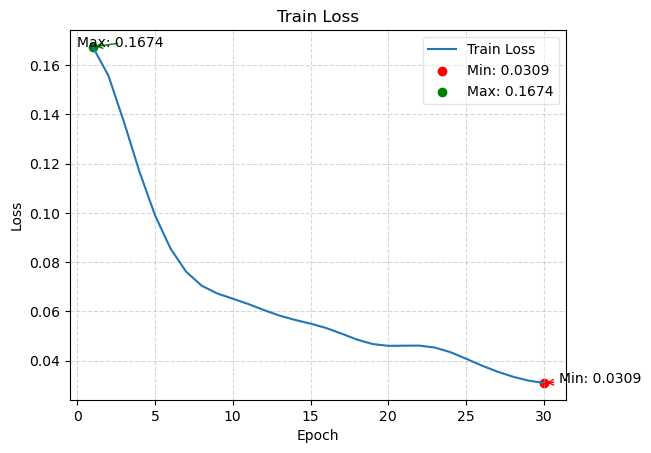

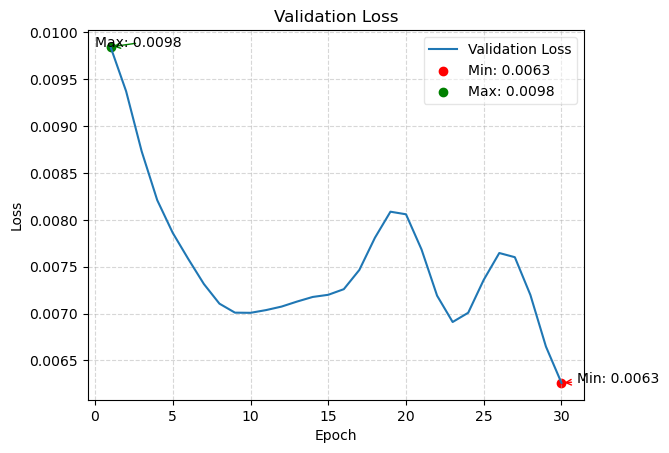

In [ ]:
# Plot train loss
plot_results(epochs, train_losses, 'Train Loss', 'Epoch', 'Loss', 'Train Loss')

# # Plot validation loss
plot_results(epochs, valid_losses, 'Validation Loss', 'Epoch', 'Loss', 'Validation Loss')


In [ ]:
def transform_list_values(lst):
    transformed_lst = [np.asarray(acc.cpu().detach().numpy()) for acc in lst]
    return transformed_lst

valid_accuracies = transform_list_values(valid_accuracies)
iou_scores = transform_list_values(iou_scores)
f1_scores = transform_list_values(f1_scores)
recalls = transform_list_values(recalls)

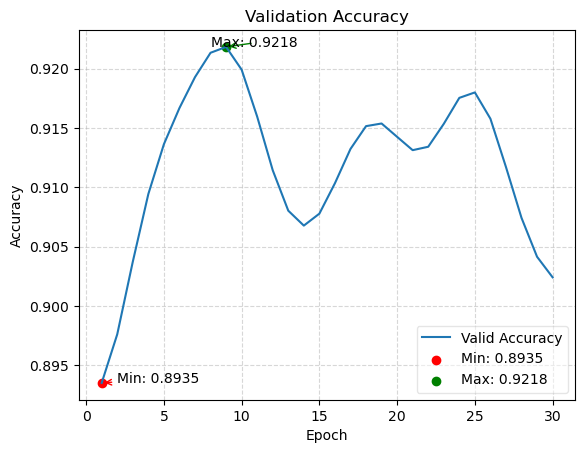

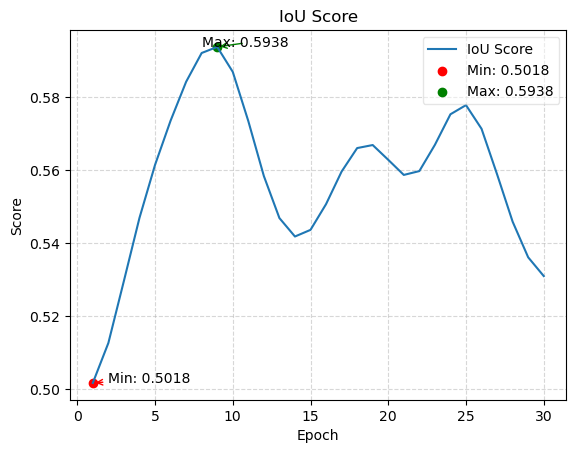

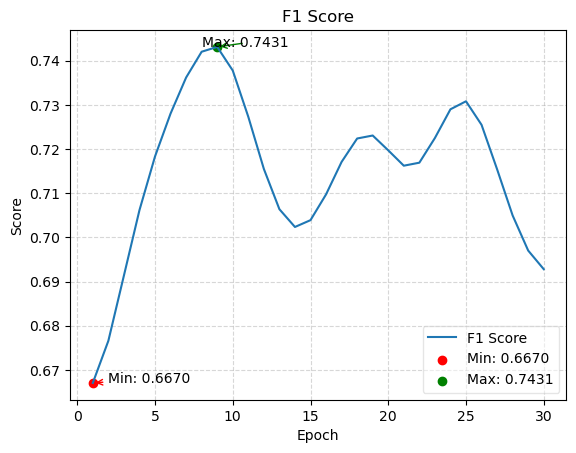

In [ ]:
# Plot valid accuracy
plot_results(epochs, valid_accuracies, 'Valid Accuracy', 'Epoch', 'Accuracy', 'Validation Accuracy')

# Plot IoU score
plot_results(epochs, iou_scores, 'IoU Score', 'Epoch', 'Score', 'IoU Score')

# Plot F1 score
plot_results(epochs, f1_scores, 'F1 Score', 'Epoch', 'Score', 'F1 Score')

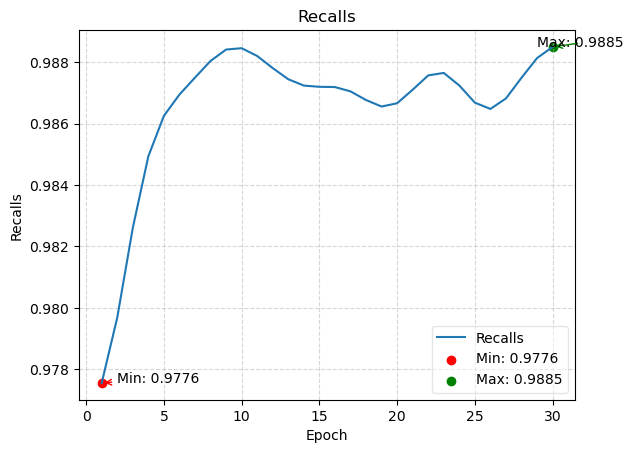

In [ ]:
# Plot F1 score
plot_results(epochs, recalls, 'Recalls', 'Epoch', 'Recalls', 'Recalls')

### we defined new class for test from not seen dataset has apple leaves we loaded data to test loader and predict and visualize predictions

In [ ]:
import matplotlib.pyplot as plt
class TestAppleCustomDataset(Dataset):
    def __init__(self, root_dir,transform =None,test_set=False):
        self.root_dir = root_dir
        self.class_names = os.listdir(root_dir)
        self.img_files = []
        self.transform = transform
        self.test_set =  test_set
        if (test_set != True):
            for i, class_name in enumerate(self.class_names):
                if class_name in ("Alternaria leaf spot","Brown spot","Grey spot","Health","Rust"):
                    img_dir = os.path.join(root_dir, class_name)
                    img_files = os.listdir(img_dir)
                    img_paths = [os.path.join(img_dir, f) for f in img_files]
                    self.img_files.extend(img_paths)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        img = Image.open(img_path).convert('RGB')

#         if self.transform:
#             image = self.transform(img)

        directory = os.path.dirname(img_path)
        class_label = os.path.basename(directory)

        return image, class_label


# Define the transforms you want to use
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])

dataset_extended = TestAppleCustomDataset("/kaggle/input/appleleaf9", transform=transform)

# # Create dataloaders for training, validation, and test sets
unseen_test_loader = DataLoader(dataset_extended, batch_size=16,shuffle = True)

### ***methods to save the state of model and load it***

In [ ]:
import copy

def save_model():
    last_model_wts = copy.deepcopy(model.state_dict())
    PATH = f"basic_Unet_30epochs.bin"
    torch.save(model.state_dict(), PATH)

def load_model(path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model
# model = load_model("/kaggle/input/100epochsmodels/Unet_VGG16_bn_EPOCHS100_CosineAnnealingLR256x256Test.bin")
save_model()

### ***getting data from new dataset and get predections***

In [ ]:
def get_preds(imgs, msks=None,labels=None):
    imgs = imgs.to(config.DEVICE, dtype=torch.float)
    preds = []
    with torch.no_grad():
        pred = model(imgs)
        #pred = (nn.Softmax()(pred)>0.5).double()
    preds.append(pred)
    imgs  = imgs.cpu().detach()
    preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

    return imgs,preds,labels

### ***plot the predections and images***

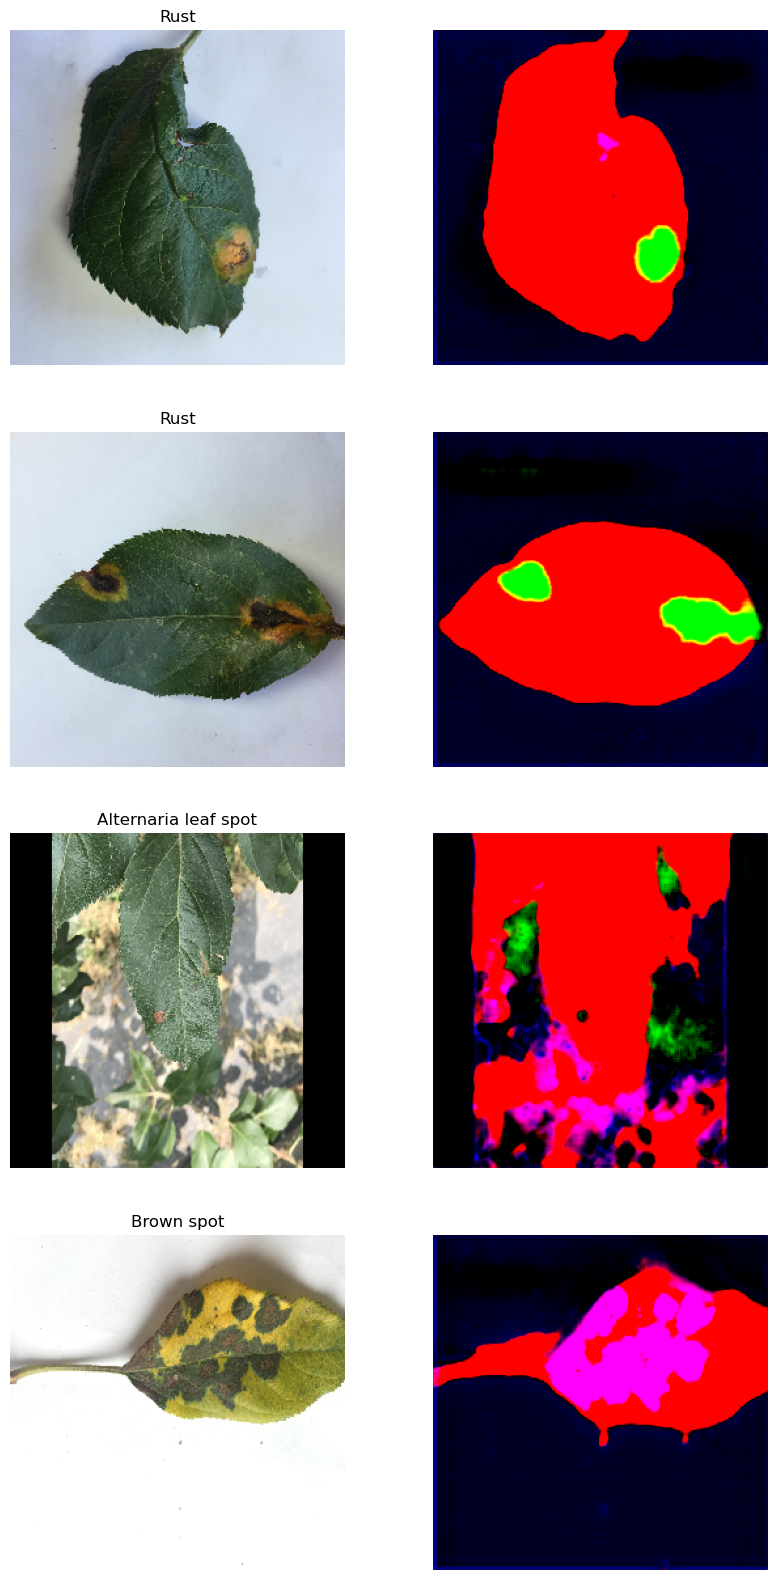

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Defining a function to display images and masks side by side
def show_batch(images, masks,labels=None):

    fig, axs = plt.subplots(len(images), 2, figsize=(10, 5*len(images)))

    for i in range(len(images)):
        axs[i,0].imshow(images[i].permute(1, 2, 0))
        if (labels):
            axs[i,0].set_title(labels[i])
        axs[i,0].axis('off')
        axs[i,1].imshow(np.transpose(masks[i].numpy(), (1, 2, 0)))
        axs[i,1].axis('off')

    plt.show()
img, mask, class_label = next(iter(test_loader)) #case of getting from test_loader
images,preds,labels = get_preds(img, mask, class_label)
show_batch(images,preds,labels)

### GRAD CAM

In [ ]:
# !pip install torchcam

from torchcam.methods import GradCAM
from torchvision import models
from PIL import Image
from torchvision.transforms.functional import  to_pil_image
from torchcam.utils import overlay_mask

def getting_cam_image(class_idx,layer,M):
    # Create an instance of the GradCAM class
    cam = GradCAM(M, layer)

    # Perform a forward pass to get the model output scores
    output = M(images.to(config.DEVICE))

    # Get the number of output classes
    num_classes = output.size(1)

    # Perform the Grad-CAM operation
    cam_image = cam(scores=output, class_idx=class_idx)

    return cam_image,cam


In [ ]:
# print(M3)
#segmentation_head
cam_image_0_conv11,cam_conv11 = getting_cam_image(0,'conv11',model)
cam_image_1_conv11,cam_conv11 = getting_cam_image(1,'conv11',model)
cam_image_2_conv11,cam_conv11 = getting_cam_image(2,'conv11',model)

# for cam in cam_image_2:
#     print(cam.shape)
cam_image_0_conv_bottleneck,cam_conv_bottleneck = getting_cam_image(0,'conv_bottleneck',model)
cam_image_1_conv_bottleneck,cam_conv_bottleneck = getting_cam_image(1,'conv_bottleneck',model)
cam_image_2_conv_bottleneck,cam_conv_bottleneck = getting_cam_image(2,'conv_bottleneck',model)

In [ ]:
def get_heatmaps(cam_image):
    heatmap = cam_image
    plt.imshow(heatmap.cpu(), cmap='jet')
    plt.axis('off')
    plt.title(f"Heatmap")
    plt.show()
    return heatmap

def overlaying_mask(images,cam_image,idx):
    result = overlay_mask(to_pil_image(images[idx]), to_pil_image(cam_image[0][idx], mode='F'), alpha=0.5)
    plt.imshow(result); plt.axis('off'); plt.show()

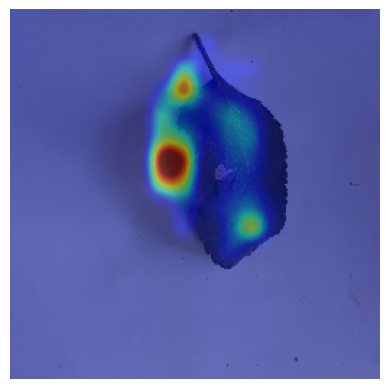

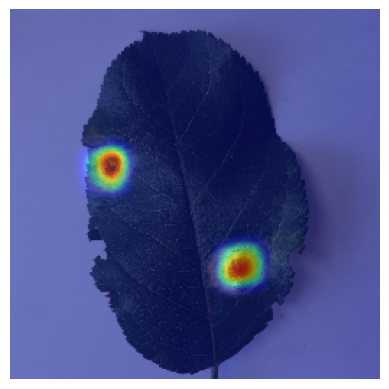

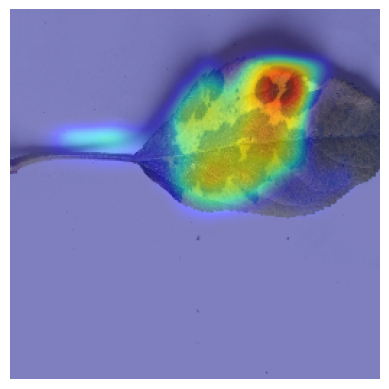

In [ ]:
cam_image_0_block5,cam_block5 = getting_cam_image(0,'block5',model)
cam_image_1_block5,cam_block5 = getting_cam_image(1,'block5',model)
cam_image_2_block5,cam_block5 = getting_cam_image(2,'block5',model)

cam_image = cam_image_0_block5 + cam_image_1_block5  + cam_image_2_block5  #preds_vit3,imgs

overlaying_mask(images,cam_image,0)
overlaying_mask(images,cam_image,1)
overlaying_mask(images,cam_image,2)

# show_image_mask(images[2],predections[0])
# cam.remove_hooks()

In [ ]:
cam.remove_hooks()